<a href="https://colab.research.google.com/github/swayangshreesamal/volatility-risk-forecasting/blob/main/03_volatility_ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Mounted at /content/drive


In [2]:
df = pd.read_csv(
    "/content/drive/My Drive/volatility-risk-forecasting/DATA/PROCESSED/volatility_features.csv",
    parse_dates=["Date"],
    index_col="Date"
)

df.head()



,Close,High,Low,Open,Volume,log_return,volatility_14d,vol_7d,vol_14d,vol_30d,vol_annualized,vol_7d_annualized,vol_14d_annualized,vol_30d_annualized,return_14d,risk_rgime
Date,,,,,,,,,,,,,,,,
2007-11-19,5907.649902,5981.799805,5893.799805,5908.049805,0,0.000135,0.014979,0.019599,0.014979,0.022943,0.20537,0.311124,0.237786,0.364201,NaN,Medium Risk
2007-11-20,5780.899902,5923.700195,5755.799805,5911.250000,0,-0.021689,0.016008,0.020814,0.016008,0.023020,0.20537,0.330417,0.254115,0.365432,NaN,Medium Risk
2007-11-21,5561.049805,5790.049805,5530.850098,5778.799805,0,-0.038772,0.018750,0.025526,0.018750,0.022889,0.20537,0.405207,0.297650,0.363356,NaN,Medium Risk
2007-11-22,5519.350098,5608.649902,5394.350098,5564.649902,0,-0.007527,0.018767,0.024657,0.018767,0.022633,0.20537,0.391423,0.297915,0.359286,NaN,Medium Risk
2007-11-23,5608.600098,5638.600098,5514.750000,5524.299805,0,0.016041,0.019118,0.017523,0.019118,0.022652,0.20537,0.278175,0.303492,0.359590,NaN,Medium Risk


In [3]:
df['risk_rgime'].value_counts(normalize=True)


,proportion
risk_rgime,
Low Risk,0.558124
Medium Risk,0.380386
High Risk,0.061490


In [4]:
features=[
    'vol_7d',
    'vol_14d',
    'vol_30d',
    'return_14d'
]
df_features=df[features].dropna()
df_features.head()

,vol_7d,vol_14d,vol_30d,return_14d
Date,,,,
2007-12-06,0.012577,0.017574,0.017307,0.008068
2007-12-07,0.009059,0.017588,0.017194,0.011219
2007-12-10,0.009816,0.016405,0.016731,0.030612
2007-12-11,0.009860,0.012312,0.016009,0.092051
2007-12-12,0.009027,0.011642,0.016029,0.109703


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[['vol_7d','vol_14d','vol_30d']])

In [6]:
kmeans = KMeans(n_clusters=3, random_state=42)
df.loc[df_features.index,'vol_regime'] = kmeans.fit_predict(X_scaled)

df['vol_regime'] = df['vol_regime'].map({
    0: 'Low Volatility',
    1: 'Medium Volatility',
    2: 'High Volatlity'
})
df['vol_regime']

,vol_regime
Date,
2007-11-19,NaN
2007-11-20,NaN
2007-11-21,NaN
2007-11-22,NaN
2007-11-23,NaN
...,...
2026-01-12,Low Volatility
2026-01-13,Low Volatility
2026-01-14,Low Volatility


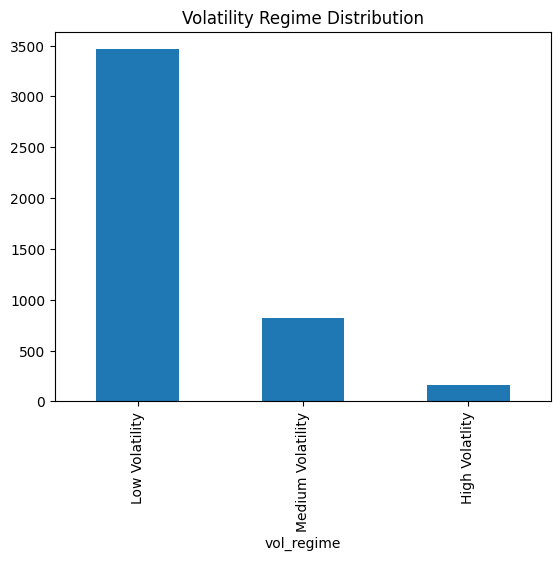

In [7]:
df['vol_regime'].value_counts().plot(kind='bar')
plt.title("Volatility Regime Distribution")
plt.show()


In [8]:
df['target_vol'] = df['vol_14d'].shift(-1)

df_model = df[features + ['target_vol']].dropna()

X = df_model[features]
y = df_model['target_vol']


In [9]:
split = int(0.8 * len(df_model))

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [10]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [11]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse


np.float64(0.0008131397754757771)

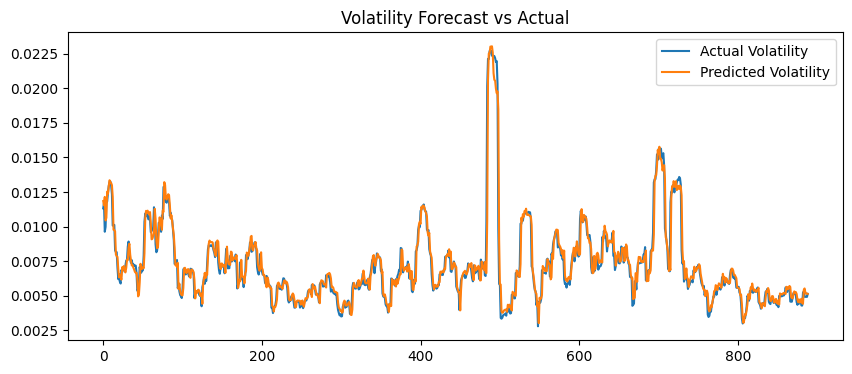

In [12]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label='Actual Volatility')
plt.plot(preds, label='Predicted Volatility')
plt.legend()
plt.title("Volatility Forecast vs Actual")
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_model =RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42
)

rf_model.fit(X_train,y_train)



RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

In [14]:
rf_preds = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_rmse

np.float64(0.00085843307428172)

In [15]:
print("Linear Regression RMSE:", rmse)
print("Random Forest RMSE:", rf_rmse)


Linear Regression RMSE: 0.0008131397754757771
Random Forest RMSE: 0.00085843307428172


In [16]:
importances = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances


,0
vol_14d,0.992733
vol_7d,0.004341
return_14d,0.002480
vol_30d,0.000446


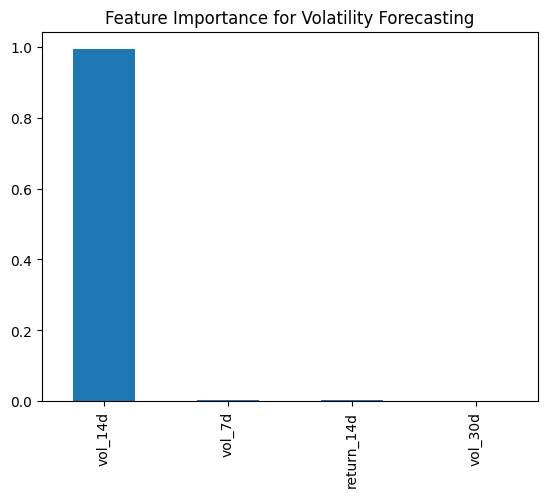

In [17]:
importances.plot(kind='bar')
plt.title("Feature Importance for Volatility Forecasting")
plt.show()


In [20]:
df.loc[X.index, "predicted_risk_regime"] = model.predict(X)

output_path = "/content/drive/My Drive/volatility-risk-forecasting/DATA/PROCESSED/volatility_ml_output.csv"
df.to_csv(output_path)

print("volatility_ml_output.csv saved successfully")

volatility_ml_output.csv saved successfully
